In [247]:
import pandas as pd  
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def preprocess(text):
    #I added the string comparison because I run into a float case
    if (type(text) == str):
        remove_numbers = ''.join(c for c in text if not c.isnumeric())
        word_tokens = tokenizer.tokenize(remove_numbers)
        lemmatized_text = lemmatizer.lemmatize(remove_numbers, 'v')
        return lemmatized_text
    else:
        return ""

df = pd.read_json('Video_Games_5.json', lines=True)
df = df.head(10000)

#I added pd.to_numeric to drop all non numeric values
df['vote'] = pd.to_numeric(df['vote'], errors='coerce')
df['helpfulness'] = [1 if float(helpful) > 5 else 0 for helpful in df['vote']] 
df['reviewText'] = [preprocess(text) for text in df['reviewText']]


count_vector = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
transformed_vector = count_vector.fit_transform(df['reviewText'])

LDA = LatentDirichletAllocation(n_components=100, random_state = 42, doc_topic_prior = 0.5, topic_word_prior = 0.5)
LDA = LDA.fit(transformed_vector)

df_topics = LDA.transform(transformed_vector)

X = df_topics
y = df["helpfulness"]

# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# random forest model creation
forest = RandomForestClassifier()
forest = forest.fit(X_train, y_train)

# RF model accuracy
print("Accuracy: " , forest.score(X_test,y_test))

Accuracy:  0.9205


In [248]:
preds = forest.predict(X_test)
probs = forest.predict_proba(X_test)

prob_1 = np.ndarray(len(probs))
count = 0
for i in probs:
    prob_1[count] = i[1]
    count = count + 1
    
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_1, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.7782129841988997

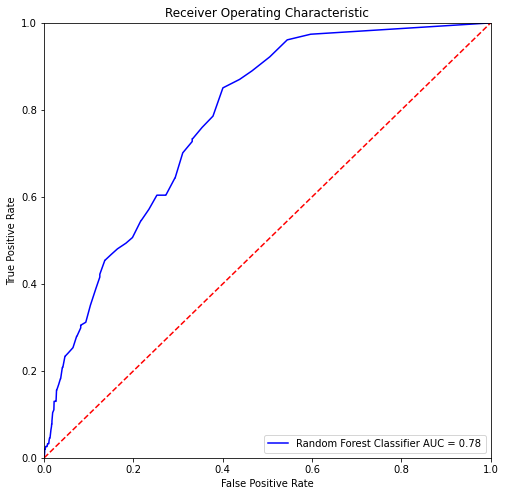

In [249]:
plt.figure(figsize=(8, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='Random Forest Classifier AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('fig1a.pdf', dpi=600)
plt.show()

In [250]:
# extract feature importances
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)

print ("Feature ranking:")
for f in range(20):
    print ("%d. Feature %d: %f" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. Feature 19: 0.037994
2. Feature 66: 0.035579
3. Feature 46: 0.029811
4. Feature 84: 0.029495
5. Feature 90: 0.027716
6. Feature 30: 0.023277
7. Feature 92: 0.021786
8. Feature 18: 0.021785
9. Feature 48: 0.021653
10. Feature 77: 0.021126
11. Feature 47: 0.020972
12. Feature 0: 0.020079
13. Feature 16: 0.020063
14. Feature 21: 0.019718
15. Feature 40: 0.019286
16. Feature 15: 0.019110
17. Feature 17: 0.018449
18. Feature 25: 0.018415
19. Feature 45: 0.018068
20. Feature 5: 0.017986


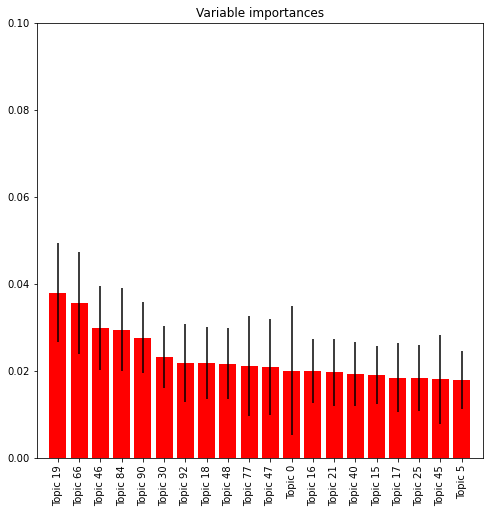

In [251]:
labels = ['Topic 19', 'Topic 66', 'Topic 46', 'Topic 84', 'Topic 90', 'Topic 30', 'Topic 92',
          'Topic 18', 'Topic 48', 'Topic 77', 'Topic 47', 'Topic 0', 'Topic 16', 'Topic 21',
          'Topic 40', 'Topic 15', 'Topic 17', 'Topic 25', 'Topic 45', 'Topic 5',]
plt.figure(figsize=(8, 8))
plt.title("Variable importances")
plt.bar(range(20), importances[indices][0:20], color="r", yerr=std[indices][0:20], align="center")
plt.xlim((-1,20))
plt.xticks(range(20), labels, rotation=90)
plt.ylim((0,0.1))
plt.savefig('fig1b.pdf', dpi=600)
plt.show()